# Artificial Neural Networks and Deep Learning





---





# Homework 1

## ⚙️ Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.gridspec as gridspec

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

In [2]:
# Load Data
#data = np.load('training_set.npz')
data = np.load('/kaggle/input/training-set/training_set.npz')

data
X = data['images']
y = data['labels']

np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([1052, 2381, 1285, 2226, 1049, 1393, 2530, 1843]))

In [3]:
# Labels dictionary
labels_dict = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

In [4]:
class_count = {}
for i in labels_dict:
    class_count[i] = np.unique(y, return_counts=True)[1][i]

class_count

{0: 1052, 1: 2381, 2: 1285, 3: 2226, 4: 1049, 5: 1393, 6: 2530, 7: 1843}

In [5]:
# see image augmentation section to fix unbalanced classes

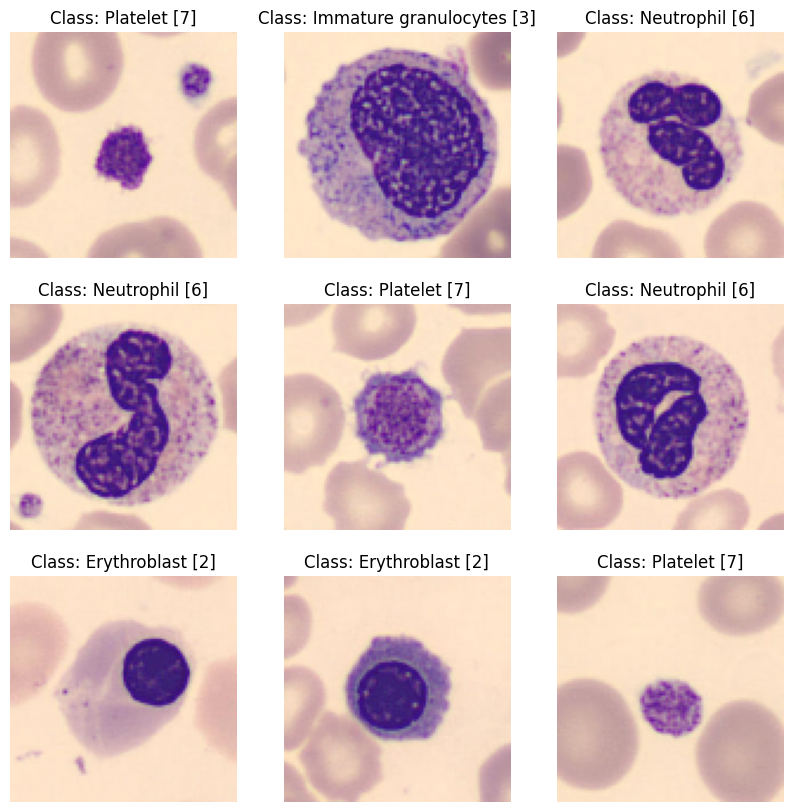

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.reshape((-1,))
for i in range(9):
    axs[i].imshow(X[i])
    axs[i].set_title(f'Class: {labels_dict[y[i][0]]} {y[i]}')
    axs[i].axis('off')

In [7]:
# Normalize data to the range [0, 1]
X = (X / 255).astype('float32')

## Image Augmentation

In [8]:
print(labels_dict)
np.unique(y, return_counts=True)

{0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature granulocytes', 4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'}


(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([1052, 2381, 1285, 2226, 1049, 1393, 2530, 1843]))

class `6: 'Neutrophil'` has the most images with 2530 samples. Have to augment to level all other classes to this one

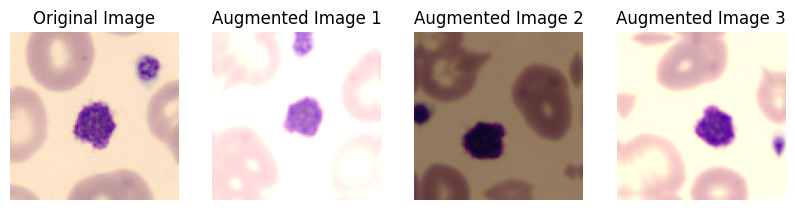

In [9]:
# Define a sequential model for image augmentation
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='Augmentation')

# Set up the figure and grid layout for displaying images
fig, axs = plt.subplots(1, 4, figsize=(10, 10))

img = X[0] # Select the first image from the dataset for example

# Display the original image
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[1].imshow(augmented_img)
axs[1].axis('off')
axs[1].set_title('Augmented Image 1')

# Apply augmentation and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[2].imshow(augmented_img)
axs[2].axis('off')
axs[2].set_title('Augmented Image 2')

# Apply augmentation and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[3].imshow(augmented_img)
axs[3].axis('off')
axs[3].set_title('Augmented Image 3')

plt.show()

This is the augmentation layer that will be used for all classes to reach 2600 samples

In [10]:
new_x = []
new_y = []
# Sweep for every class
for clas in class_count:
    print(f'Class: {clas}')
    # Filter images of current class
    class_images = X[y.flatten() == clas]

    while class_count[clas] < 2600:
        # Select a random image from the current class
        random_index = np.random.randint(0, class_images.shape[0])
        original_img = class_images[random_index]

        # Apply augmentation layer
        augmented_img = np.clip(augmentation(original_img), 0., 1.)

        # Add new image and its label to data
        new_x.append(augmented_img)
        new_y.append(clas)

        class_count[clas] += 1

# Concatenate the augmented data into the whole data
new_x = np.array(new_x)
new_y = np.array(new_y).reshape(-1, 1)

X = np.concatenate([X, new_x], axis=0)
y = np.concatenate([y, new_y], axis=0)

Class: 0
Class: 1
Class: 2
Class: 3
Class: 4
Class: 5
Class: 6
Class: 7


In [11]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600]))

## 🔄 Process Data

In [12]:
# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

In [13]:
test_val_size = 0.05 # parameter to tune

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_val_size, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (18720, 96, 96, 3), y_train shape: (18720, 8)
X_val shape: (1040, 96, 96, 3), y_val shape: (1040, 8)
X_test shape: (1040, 96, 96, 3), y_test shape: (1040, 8)


## 🧮 Define Network Parameters

In [14]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [15]:
# Number of training epochs
epochs = 100 # parameter to tune

# Batch size for training
batch_size = 32 # parameter to tune

# Learning rate: step size for updating the model's weights
learning_rate = 0.001 # parameter to tune

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 100
Batch Size: 32
Learning Rate: 0.001


## 🛠️ Build the Model

In [16]:
# Todo: Add augmentation
# # Define a data augmentation pipeline with random flip, brightness, and translation
# augmentation = tf.keras.Sequential([
#     tfkl.RandomFlip("horizontal"),
#     tfkl.RandomBrightness(0.2, value_range=(0,1)),
#     tfkl.RandomTranslation(0.2,0.2),
# ], name='preprocessing')

# # Build the model with specified input and output shapes
# model = build_model(augmentation=augmentation)

# # Display a summary of the model architecture
# model.summary(expand_nested=True, show_trainable=True)

# # Plot the model architecture
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


In [21]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=None,
    seed=seed
):

    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Flatten(name='flatten')(x)
    x = tfkl.Dense(units=output_shape, name='dense')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 8)             │    294,920 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

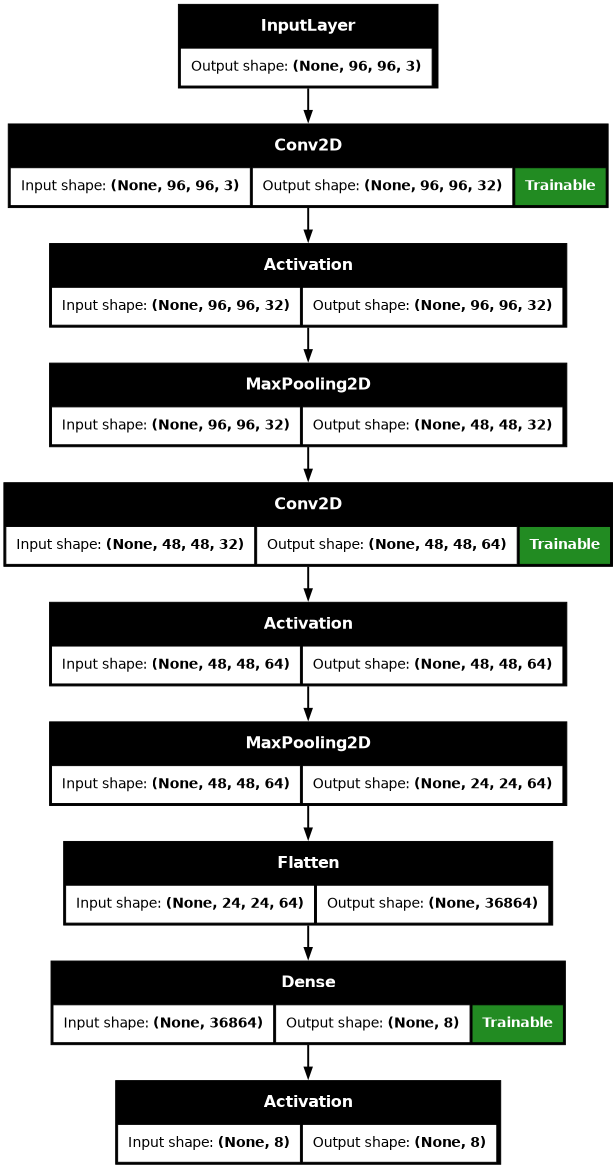

In [22]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

In [23]:
# Define the patience value for early stopping
patience = 10 # parameter to tune

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [24]:
X_train.shape,y_train.shape

((18720, 96, 96, 3), (18720, 8))

In [25]:
'''# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')


# Save the trained model to a file with the accuracy included in the filename
model_filename = 'cell_v1'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model'''

"# Train the model with early stopping callback\nhistory = model.fit(\n    x=X_train,\n    y=y_train,\n    batch_size=batch_size,\n    epochs=epochs,\n    validation_data=(X_val, y_val),\n    callbacks=callbacks\n).history\n\n\n# Calculate and print the final validation accuracy\nfinal_val_accuracy = round(max(history['val_accuracy'])* 100, 2)\nprint(f'Final validation accuracy: {final_val_accuracy}%')\n\n\n# Save the trained model to a file with the accuracy included in the filename\nmodel_filename = 'cell_v1'.keras'\nmodel.save(model_filename)\n\n# Delete the model to free up resources\ndel model"

In [26]:
'''# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()'''

"# Plot training and validation loss\nplt.figure(figsize=(15, 2))\nplt.plot(history['loss'], label='Training loss', alpha=.8)\nplt.plot(history['val_loss'], label='Validation loss', alpha=.8)\nplt.title('Loss')\nplt.legend()\nplt.grid(alpha=.3)\n\n# Plot training and validation accuracy\nplt.figure(figsize=(15, 2))\nplt.plot(history['accuracy'], label='Training accuracy', alpha=.8)\nplt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)\nplt.title('Accuracy')\nplt.legend()\nplt.grid(alpha=.3)\nplt.show()"

## 💡 K-Fold Cross-Validation

In [28]:
# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train_val, y_train_val)):

    print("Starting training on fold num: {}".format(fold_idx+1))

    # Build a new dropout model for each fold
    k_model = build_model(input_shape)

    # Create an EarlyStopping callback
    early_stopping = tfk.callbacks.EarlyStopping(
        monitor='val_mse',
        mode='min',
        patience=patience,
        restore_best_weights=True
    )

    callbacks = [early_stopping]

    # Train the model on the training data for this fold
    history = k_model.fit(
    x = X_train_val[train_idx],
    y = y_train_val[train_idx],
    validation_data=(X_train_val[valid_idx], y_train_val[valid_idx]),
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 1
    ).history

    # Evaluate the model on the validation data for this fold
    score = k_model.evaluate(X_train_val[valid_idx], y_train_val[valid_idx], verbose=0)
    scores.append(score[1])

    # Calculate the best epoch for early stopping
    best_epoch = len(history['loss']) - patience
    best_epochs.append(best_epoch)

    # Store the training history for this fold
    histories.append(history)

Starting training on fold num: 1
Epoch 1/100


I0000 00:00:1731189499.745933     100 service.cc:145] XLA service 0x5686cd4e0eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731189499.745995     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 29/494 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1355 - loss: 2.3776

I0000 00:00:1731189501.858375     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3611 - loss: 1.6896 - val_accuracy: 0.6065 - val_loss: 1.0749
Epoch 2/100
 28/494 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6131 - loss: 1.0109

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mse` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6167 - loss: 1.0036 - val_accuracy: 0.6731 - val_loss: 0.8955
Epoch 3/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6883 - loss: 0.8267 - val_accuracy: 0.6969 - val_loss: 0.8574
Epoch 4/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7258 - loss: 0.7362 - val_accuracy: 0.6946 - val_loss: 0.8550
Epoch 5/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7515 - loss: 0.6690 - val_accuracy: 0.6903 - val_loss: 0.8944
Epoch 6/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7747 - loss: 0.6114 - val_accuracy: 0.6961 - val_loss: 0.9051
Epoch 7/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7970 - loss: 0.5570 - val_accuracy: 0.6898 - val_loss: 0.9530
Epoch 8/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8168 - loss: 0.5086 - val_accuracy: 0.6872 - val_loss: 1.0375
Epoch 9/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8287 - loss: 0.4788 - val_accuracy: 0.6943

MSE
Mean: 0.6699
Std:  0.0086


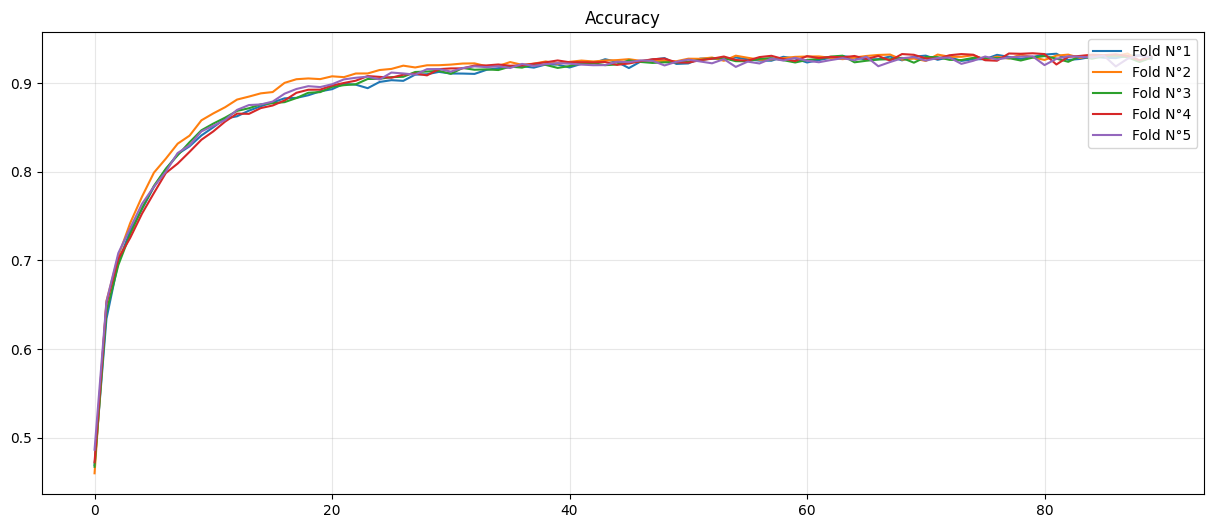

In [31]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Print mean and standard deviation of MSE scores
print("MSE")
print(f"Mean: {np.mean(scores).round(4)}\nStd:  {np.std(scores).round(4)}")

# Create a figure for MSE visualization
plt.figure(figsize=(15,6))

# Plot MSE for each fold
for fold_idx in range(num_folds):
    plt.plot(histories[fold_idx]['accuracy'][:-patience], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
    plt.title('Accuracy')
    plt.legend(loc='upper right')
    plt.grid(alpha=.3)

# Show the plot
plt.show()

In [32]:
# Calculate the average best epoch
avg_epochs = int(np.mean(best_epochs))
print(f"Best average epoch: {avg_epochs}")

Best average epoch: 90


In [33]:
# Build the final model using the calculated average best epoch
final_model = build_model(input_shape)

# Train the final model on the combined training and validation data
final_history = final_model.fit(
    x = X_train_val,
    y = y_train_val,
    batch_size = batch_size,
    epochs = avg_epochs
).history

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'cell_v2.keras'
final_model.save(model_filename)

# Delete the model to free up resources
del final_model

Epoch 1/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3547 - loss: 1.6869
Epoch 2/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6143 - loss: 1.0293
Epoch 3/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6790 - loss: 0.8651
Epoch 4/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7081 - loss: 0.7845
Epoch 5/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7336 - loss: 0.7161
Epoch 6/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7566 - loss: 0.6669
Epoch 7/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7774 - loss: 0.6145
Epoch 8/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7940 - loss: 0.5764
Epoch 9/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8055 - loss: 0.5394
Epoch 10/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8217 - loss: 0.5019
Epoch 11/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8294 - loss: 0.4799
Epoch 12/90
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

## 🕹️ Use the Model - Make Inference

In [34]:
# Load the saved model
model = tfk.models.load_model('cell_v2.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 8)             │    294,920 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 942,938 (3.60 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 628,626 (2.40 MB)

Accuracy score over the test set: 0.6904
Precision score over the test set: 0.7044
Recall score over the test set: 0.6904
F1 score over the test set: 0.6884


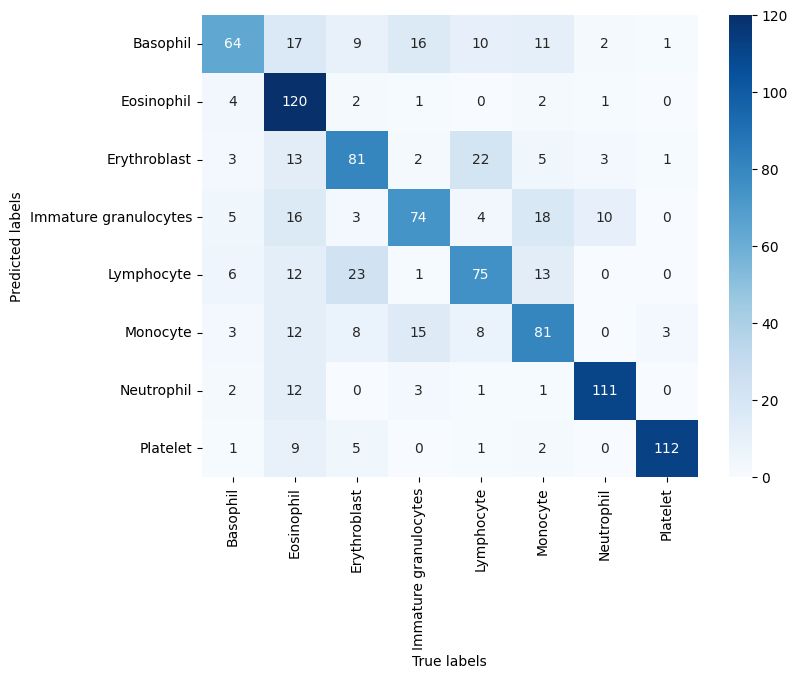

In [35]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=list(labels_dict.values()), yticklabels=list(labels_dict.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission







To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:







```python



# file: model.py



class Model:



    def __init__(self):



        """Initialize the internal state of the model."""







    def predict(self, X):



        """Return a numpy array with the labels corresponding to the input X."""



```







The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.







❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [38]:
%%writefile model.py



import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:

    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.
        The following is an example loading the weights of a pre-trained
        model.
        """
        
        self.neural_network = tfk.models.load_model('cell_v2.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [39]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py cell_v2.keras

# from google.colab import files
# files.download(filename)

  adding: model.py (deflated 56%)
  adding: cell_v2.keras (deflated 19%)
